# 순환 신경망으로 IMDB 리뷰 분류하기

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/9-2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [1]:
# %pip install tensorflow

In [2]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

2024-06-26 19:50:10.903651: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/user/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## IMDB 리뷰 데이터셋

- imdb 말뭉치에 포함된 단어 300개로 사용하는 문장들을 불러옴.

In [47]:
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=300)


In [48]:
import numpy as np

# npz 파일로 저장 (여러 배열을 한 번에 저장)
np.savez('chapter9_arrays.npz', train_input=train_input, train_target=train_target, test_input=test_input, test_target=test_target)


In [49]:
# npz 파일에서 배열들 읽어오기
data = np.load('chapter9_arrays.npz',allow_pickle=True)

# 각 배열에 접근
loaded_arr1 = data['train_input']

print("Loaded arr1:")
print(loaded_arr1)
print(loaded_arr1[0])


Loaded arr1:
[list([1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 2, 284, 5, 150, 4, 172, 112, 167, 2, 2, 2, 39, 4, 172, 2, 2, 17, 2, 38, 13, 2, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 2, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 2, 12, 8, 2, 8, 106, 5, 4, 2, 2, 16, 2, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 2, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 7, 4, 2, 2, 13, 104, 88, 4, 2, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 2, 26, 2, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32])
 list([1, 194, 2, 194, 2, 78, 228, 5, 6, 2, 2, 2, 134, 26, 4, 2, 8, 118, 2, 14, 2, 20, 13, 119, 2, 189, 102, 5, 207, 110, 2, 21, 14, 69, 188, 8, 30, 23, 7, 4, 249,

- 1: 통상적으로 문장, 샘플의 시작을 1로 지정
- 2: 300개(num words)의 단어 안에 포함되지 않은 단어는 2로 지정.
    - 너무 작게 설정하면 2가 많아짐


In [50]:
type(train_input)

numpy.ndarray

In [51]:
print(train_input.shape, test_input.shape)

(25000,) (25000,)


In [52]:
print(len(train_input[0]))

218


In [53]:
print(len(train_input[1]))

189


In [54]:
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 2, 284, 5, 150, 4, 172, 112, 167, 2, 2, 2, 39, 4, 172, 2, 2, 17, 2, 38, 13, 2, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 2, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 2, 12, 8, 2, 8, 106, 5, 4, 2, 2, 16, 2, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 2, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 7, 4, 2, 2, 13, 104, 88, 4, 2, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 2, 26, 2, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [55]:
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


긍정적인 리뷰는 1 / 부정적인 리뷰는 0

### 훈련세트 준비
20% 정도를 validation data로


In [56]:
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [57]:
import numpy as np

lengths = np.array([len(x) for x in train_input])

In [58]:
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


In [59]:
# %pip install matplotlib

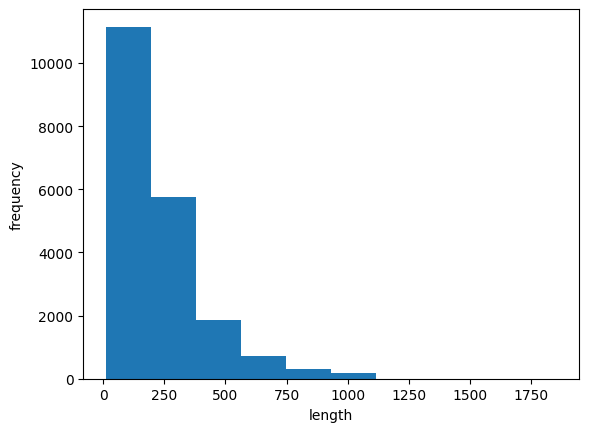

In [60]:
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

길이가 긴 리뷰가 있다.    
적절한 길이의 토큰 길이를 선정해야함.    
너무 긴 토큰 길이를 해버리면 짧은 문장들은 빈칸으로 채워야한다는 단점이 있다.


### 시퀀스 패딩

In [61]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)

토큰을 줄이면 연산속도가 빨라진다.
maxlen = 100개보다 긴것들은 짜르고 이하인것은 패딩

In [66]:
print(train_seq.shape)

(20000, 100)


In [67]:
print(train_seq[0])

[ 10   4  20   9   2   2   2   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10   2   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10   2 158]


In [64]:
print(train_input[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 2, 158]


padding 처리된 문장과 비교해보면 뒤 10개의 단어가 같다.     
100개보다 길었기 때문에 앞부분을 짜름. (=뒤의 단어들이 더 의미가 있다고 가정)    


In [65]:
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2   2   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94   2   2   2   2  11 190
  24   2   2   7  94 205   2  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


^앞부분에 패딩 되어있음

In [69]:
val_seq = pad_sequences(val_input, maxlen=100)
#검증세트도 똑같이 100개로 만듦, 100개의 타임스텝 or 100개의 토큰

## 순환 신경망 만들기

In [98]:
from tensorflow import keras

model = keras.Sequential() 

model.add(keras.layers.SimpleRNN(8, input_shape=(100, 300))) #가장 기본적인 RNN 신경망 #input shape(100개의 토큰, 300개의 단어사전 )
model.add(keras.layers.Dense(1, activation='sigmoid')) #순환셀이 하나인 간단한 모델

/Users/user/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10 14 9 등 .. 아무 의미 없지만 처리과정에서 가중치를 곱하게 되면 의미부여가 될 수 있다.    
원-핫 인코딩을 만들어줘야함 --> utiles.to_categorical

In [99]:
train_oh = keras.utils.to_categorical(train_seq)
# 

In [100]:
print(train_oh.shape)

(20000, 100, 300)


In [101]:
print(train_oh[0][0][:12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [102]:
print(np.sum(train_oh[0][0]))

1.0


원핫인코딩이 잘 되고있음을 확인함

In [103]:
val_oh = keras.utils.to_categorical(val_seq)

In [104]:
model.summary()
# RNN CLASS 뉴런이 8개, dense층 뉴런 1개. 출력은 8*1+가중치1개 = 9개
# 300*8 = 2400개 +8(뉴런)*8(순환층의 출력이 8개의 뉴런에 다시 연결됨) + 8개의 절편

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_11 (SimpleRNN)       │ (None, 8)              │         2,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,481 (9.69 KB)

 Trainable params: 2,481 (9.69 KB)

 Non-trainable params: 0 (0.00 B)

## 순환 신경망 훈련하기 - 모델훈련

In [85]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4) 
model.compile(optimizer=rmsprop, loss='binary_crossentropy', #이진분류 손실함수
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.4986 - loss: 0.6985 - val_accuracy: 0.5024 - val_loss: 0.6958
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5084 - loss: 0.6946 - val_accuracy: 0.5074 - val_loss: 0.6942
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5115 - loss: 0.6931 - val_accuracy: 0.5128 - val_loss: 0.6930
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5192 - loss: 0.6916 - val_accuracy: 0.5236 - val_loss: 0.6913
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5358 - loss: 0.6889 - val_accuracy: 0.5522 - val_loss: 0.6846
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5773 - loss: 0.6797 - val_accuracy: 0.5924 - val_loss: 0.6738
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.6190 - loss: 0.6680 - val_accuracy: 0.6198 - val_loss: 0.6640
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.6435 - loss: 0.6571 -

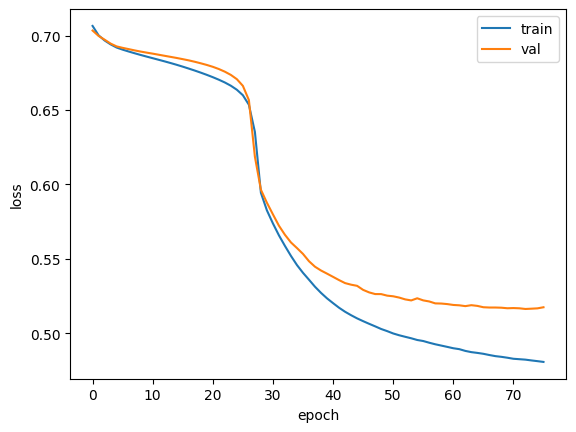

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 단어 임베딩을 사용하기

원핫인코딩을 하면 각각의 토큰에 상관관계를 없애버림 0010 1000 0100    
임베딩 : 단어의 상관관계를 실수벡터로 나타낸것

In [105]:
model3 = keras.Sequential()

model3.add(keras.layers.Embedding(300, 16, input_length=100)) # 16개의 벡터로 토큰 하나를 출력하는것
model3.add(keras.layers.SimpleRNN(8))
model3.add(keras.layers.Dense(1, activation='sigmoid'))
model3.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_12 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [106]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model3.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5064 - loss: 0.6950 - val_accuracy: 0.5130 - val_loss: 0.6930
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5337 - loss: 0.6909 - val_accuracy: 0.6100 - val_loss: 0.6796
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6180 - loss: 0.6752 - val_accuracy: 0.6568 - val_loss: 0.6581
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6660 - loss: 0.6527 - val_accuracy: 0.6956 - val_loss: 0.6357
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6931 - loss: 0.6312 - val_accuracy: 0.7096 - val_loss: 0.6179
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7092 - loss: 0.6134 - val_accuracy: 0.7226 - val_loss: 0.6001
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7177 - loss: 0.5991 - val_accuracy: 0.7246 - val_loss: 0.5875
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7263 - loss: 0.5844 - 

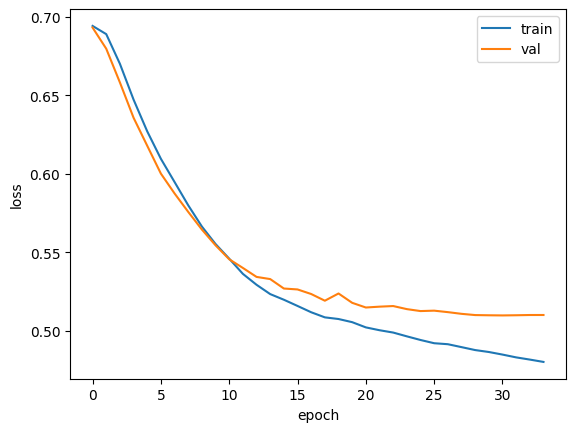

In [107]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()